In [1]:
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
df = sns.load_dataset("titanic")
# 欠損値を落とす
df.dropna(inplace=True)
# X, y を作成
X = df.loc[:, (df.columns!="survived") & (df.columns!="alive")]
y = df["survived"]
# カテゴリ変数をエンコーディングする(決定木をsklearnで扱うためにカテゴリ変数のエンコーディングが必要)
oe = OrdinalEncoder()
oe.set_output(transform="pandas")
X = oe.fit_transform(X)
# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# XGBoost
- GBDTに**正則化項**を加えることで過学習を防ぐ。つまり、XGBoostは **Regularized GBDT** とも言える！  
⇒ 木が大きくなりすぎないようにする。一つのモデルで残差を大きく減らしすぎないようにするような工夫が施される。  
- ランダムフォレスト同様、各弱学習器で用いる特徴量をランダムに選択することで弱学習器同士の相関を減らしてアンサンブル(**Column Subsampling**)
- **shrinkage**(適当な係数をかけることで過学習を防ぐ)

In [13]:
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.01, 
              eval_metric="auc", 
              early_stopping_rounds=10,
              importance_type="total_gain",
              random_state=0
             )
# eval_setに指定された (X_test,y_test) から AUC を計算して、AUCが向上しなくなった時点でearly stopするようにする
xgb.fit(X_train, y_train, eval_set=[(X_test,y_test)], verbose=True)


[0]	validation_0-auc:0.89904
[1]	validation_0-auc:0.89663
[2]	validation_0-auc:0.89663
[3]	validation_0-auc:0.89663
[4]	validation_0-auc:0.89663
[5]	validation_0-auc:0.89663
[6]	validation_0-auc:0.89103
[7]	validation_0-auc:0.89103
[8]	validation_0-auc:0.88942
[9]	validation_0-auc:0.89103
[10]	validation_0-auc:0.88622


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None,
              importance_type='total_gain', interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=0, ...)

In [14]:
from sklearn.metrics import roc_auc_score
y_pred_xgb = xgb.predict_proba(X_test)
print(f"XGBoost ACU: {roc_auc_score(y_test, y_pred_xgb[:, 1])}")

XGBoost ACU: 0.8990384615384616


<AxesSubplot:>

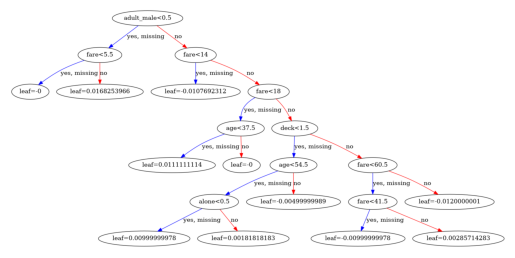

In [15]:
import xgboost
xgboost.plot_tree(xgb, num_trees=0)

# LightGBM
- XGBoost同様、勾配ブースティング決定木のアルゴリズム
- XGBoostよりも高速で精度が高くなるケースが多い。
    - **leaf wise**で決定木を作ることで高速化
    - **histogram based** で決定木のノードを分割することで高速化
    - **Gradient-based One-Side Sampling(GOSS)**で学習データを減らし高速化
    - **Exclusive Feature Bun ding(EFB)**で特徴量を減らし高速化

In [22]:
import lightgbm as lgb
lgbmc = lgb.LGBMClassifier(boosting_type="goss", max_depth=5, random_state=0)
eval_set = [(X_test, y_test)]
callbacks = []
callbacks.append(lgb.early_stopping(stopping_rounds=10))
callbacks.append(lgb.log_evaluation())
lgbmc.fit(X_train, y_train, eval_set=eval_set, callbacks=callbacks)

[1]	valid_0's binary_logloss: 0.56902
Training until validation scores don't improve for 10 rounds
[2]	valid_0's binary_logloss: 0.536293
[3]	valid_0's binary_logloss: 0.50876
[4]	valid_0's binary_logloss: 0.485108
[5]	valid_0's binary_logloss: 0.464864
[6]	valid_0's binary_logloss: 0.447251
[7]	valid_0's binary_logloss: 0.433086
[8]	valid_0's binary_logloss: 0.41859
[9]	valid_0's binary_logloss: 0.408127
[10]	valid_0's binary_logloss: 0.400311
[11]	valid_0's binary_logloss: 0.400311
[12]	valid_0's binary_logloss: 0.400311
[13]	valid_0's binary_logloss: 0.400311
[14]	valid_0's binary_logloss: 0.400311
[15]	valid_0's binary_logloss: 0.400311
[16]	valid_0's binary_logloss: 0.400311
[17]	valid_0's binary_logloss: 0.400311
[18]	valid_0's binary_logloss: 0.400311
[19]	valid_0's binary_logloss: 0.400311
[20]	valid_0's binary_logloss: 0.400311
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.400311


LGBMClassifier(boosting_type='goss', max_depth=5, random_state=0)

In [25]:
y_pred_lgbmc = lgbmc.predict_proba(X_test)
print(f"light gbm AUC: {roc_auc_score(y_test, y_pred_lgbmc[:, 1])}")

light gbm AUC: 0.9383012820512822


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

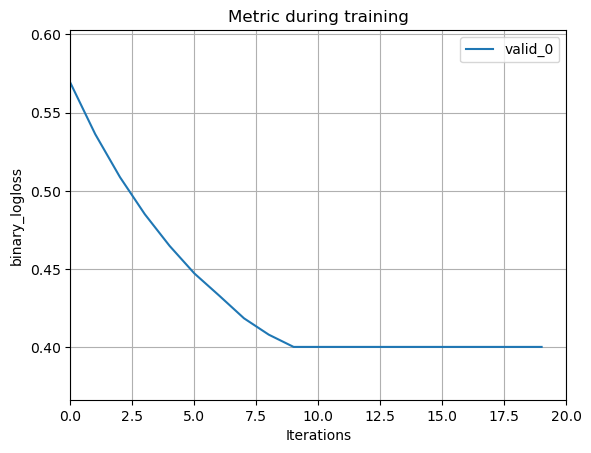

In [27]:
# 学習曲線
lgb.plot_metric(lgbmc)

<AxesSubplot:>

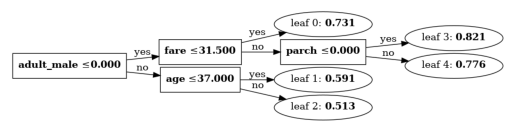

In [28]:
lgb.plot_tree(lgbmc, tree_index=0)

# CatBoost

In [40]:
from catboost import CatBoostClassifier
import numpy as np

# CatBoostの際はカテゴリカル変数をエンコードする必要がないので、新たにデータを用意する
df = sns.load_dataset("titanic")
# 欠損値を落とす
df.dropna(inplace=True)
# X, y を作成
X = df.loc[:, (df.columns!="survived") & (df.columns!="alive")]
y = df["survived"]
category_cols = X.select_dtypes(exclude=np.number).columns.to_list()
# 訓練データとテストデータに分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [42]:
cbc = CatBoostClassifier(iterations=1000, learning_rate=0.01, cat_features=category_cols)
eval_set = [(X_test, y_test)]
cbc.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=10, verbose=True)

0:	learn: 0.6885366	test: 0.6868442	best: 0.6868442 (0)	total: 10.6ms	remaining: 10.6s
1:	learn: 0.6814490	test: 0.6793775	best: 0.6793775 (1)	total: 28.1ms	remaining: 14s
2:	learn: 0.6760508	test: 0.6726860	best: 0.6726860 (2)	total: 45.9ms	remaining: 15.3s
3:	learn: 0.6712676	test: 0.6671826	best: 0.6671826 (3)	total: 63.9ms	remaining: 15.9s
4:	learn: 0.6653107	test: 0.6593995	best: 0.6593995 (4)	total: 81.3ms	remaining: 16.2s
5:	learn: 0.6598695	test: 0.6518437	best: 0.6518437 (5)	total: 98.3ms	remaining: 16.3s
6:	learn: 0.6558456	test: 0.6467404	best: 0.6467404 (6)	total: 114ms	remaining: 16.2s
7:	learn: 0.6515199	test: 0.6413944	best: 0.6413944 (7)	total: 132ms	remaining: 16.4s
8:	learn: 0.6471426	test: 0.6356173	best: 0.6356173 (8)	total: 148ms	remaining: 16.3s
9:	learn: 0.6431772	test: 0.6310513	best: 0.6310513 (9)	total: 167ms	remaining: 16.5s
10:	learn: 0.6392733	test: 0.6260433	best: 0.6260433 (10)	total: 180ms	remaining: 16.2s
11:	learn: 0.6349835	test: 0.6211657	best: 0.621

In [43]:
y_pred_cbc = cbc.predict_proba(X_test)
print(f"catboost AUC: {roc_auc_score(y_test, y_pred_cbc[:, 1])}")

catboost AUC: 0.8942307692307693


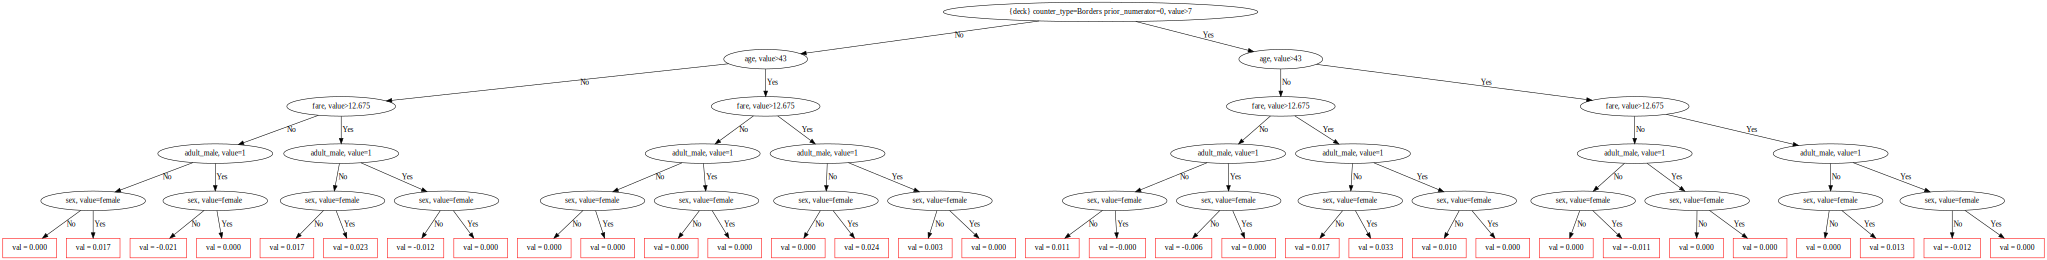

In [46]:
from catboost import Pool
# デフォルトではモデルに特徴量のデータが保存されていないので、Poolを用いて特徴量の詳細を指定する必要がある
pool = Pool(X_train, y_train, cat_features=category_cols)
cbc.plot_tree(tree_idx=1, pool=pool)